Import useful packages

In [330]:
from torchvision import datasets, transforms
from torchvision.datasets import EMNIST
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Download the EMNIST dataset

In [331]:
model_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = EMNIST(
    root = './data',
    split = 'balanced',
    train = True,
    download = True,
    transform = model_transforms
)

In [332]:
emnist_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    shuffle = True
)

label_names = train_dataset.classes

classes_map = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

Visualize a few samples from the data

Number of samples in the dataset: 112800
Number of samples in a single batch: 64


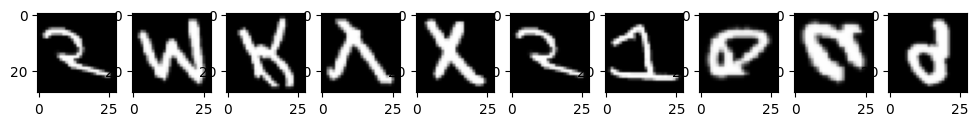

In [333]:
dataiter = iter(emnist_dataloader)
batch_images, batch_labels = next(dataiter)
samples_amount = len(train_dataset)

print(f"Number of samples in the dataset: {samples_amount}")
print(f"Number of samples in a single batch: {batch_images.shape[0]}")

# Visualiziation

random_images_indices = np.random.choice(range(64), 10)
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(batch_images[random_images_indices[i]].numpy().squeeze(), cmap='Greys_r')

Implement the neural network architecture.

In [334]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [335]:
class EMNIST_MLP(nn.Module):
    def __init__(self):
        super(EMNIST_MLP, self).__init__()
        # Now we will define the different layers.
        self.flatten = nn.Flatten()
        self.hidden_layer_1 = nn.Linear(784, 256)
        self.hidden_layer_2 = nn.Linear(256, 128)
        self.hidden_layer_3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 47)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.hidden_layer_1(x))
        x = F.relu(self.hidden_layer_2(x))
        x = F.relu(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)
    
model = EMNIST_MLP()

We will now choose a random image out of the database and pass it through our neural network and see its' prediction.

In [336]:
import matplotlib.gridspec as gridspec

In [337]:
def view_classify(img, log_ps, label_names):
    # Convert log probabilities to probabilities and squeeze
    ps = torch.exp(log_ps).detach().cpu().numpy().squeeze()
    n = len(label_names)
    half = n // 2 + n % 2
    
    # Ensure image is on CPU and reshaped
    img = img.cpu().view(28, 28)

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), ncols=2)
    ax1.imshow(img.numpy(), cmap='Greys_r')
    ax1.axis('off')

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(label_names)))
    ax2.set_yticklabels(label_names)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.title("Random sample classification")
    plt.show()

In [338]:
def random_prediction_example(data_loader, model):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    img = images[0].unsqueeze(0)  # Add batch dimension: [1, 1, 28, 28]

    with torch.no_grad():
        log_ps = model(img)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        predicted_class = top_class.item()

    view_classify(img.squeeze(0), log_ps, train_dataset.classes)
    return ps, predicted_class

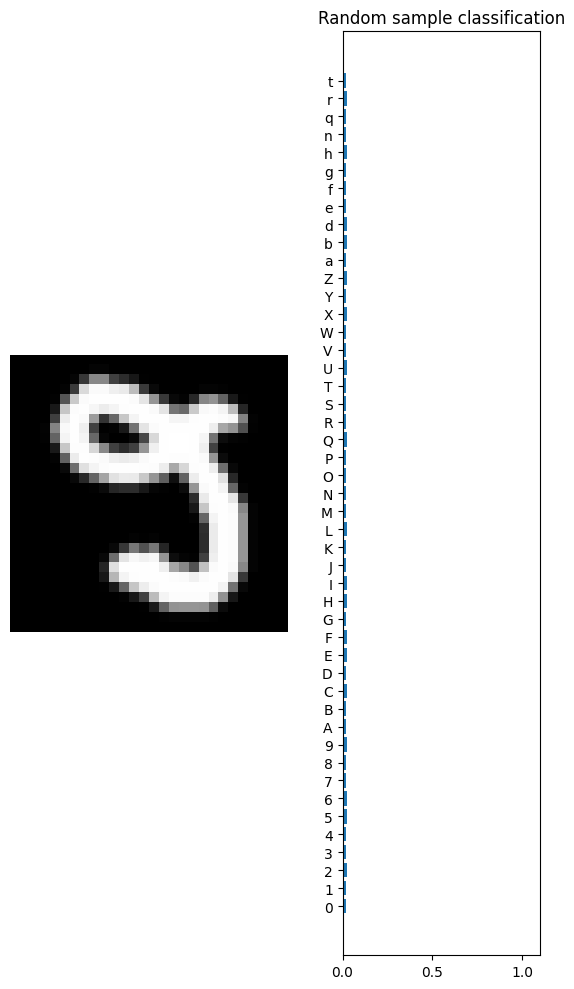

In [339]:
preds_conf, pred_class = random_prediction_example(emnist_dataloader, model)

In [340]:
print(f"Predicted class: {classes_map[pred_class]}")

Predicted class: d


Split the data to 80% for train set and 20% test set

In [341]:
from torch.utils.data import DataLoader, random_split

In [342]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
trainset, valset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=False)

Set hyperparameters.

In [343]:
learning_rate = 0.008
epochs = 10

In [344]:
model = EMNIST_MLP()

optimizer = optim.SGD(model.parameters(), lr = learning_rate)

criterion = nn.NLLLoss()

In [357]:
def train_model(model, optimizer, criterion, epochs, train_loader, val_loader, is_image_input=False):
    train_losses, val_losses = [], []
    for e in range(epochs):
        running_loss = 0
        running_val_loss = 0
        for images, labels in train_loader:
            model.train()
            
            optimizer.zero_grad() # Clears the gradients.
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        else:
            val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    # Flatten Fashion-MNIST images into a 784 long vector
                    model.eval() # set model in evaluation mode

                    # TODO: compute the Validation Loss
                    ######################
                    output = model(images)  # Forward pass
                    val_loss = criterion(output, labels)  # Compute the validation loss
                    ######################
                    
                    running_val_loss += val_loss.item()
                    
            train_losses.append(running_loss/len(train_loader))
            val_losses.append(running_val_loss/len(val_loader))
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                    "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))
    return train_losses, val_losses
            

In [346]:
  # 6.1. Train the model.
train_losses, val_losses = train_model(model, optimizer, criterion, epochs,
                                       train_loader, val_loader, is_image_input=True)

Epoch: 1/10..  Training Loss: 3.727..  Validation Loss: 3.256.. 
Epoch: 2/10..  Training Loss: 2.311..  Validation Loss: 1.773.. 
Epoch: 3/10..  Training Loss: 1.567..  Validation Loss: 1.448.. 
Epoch: 4/10..  Training Loss: 1.351..  Validation Loss: 1.291.. 
Epoch: 5/10..  Training Loss: 1.208..  Validation Loss: 1.153.. 
Epoch: 6/10..  Training Loss: 1.088..  Validation Loss: 1.058.. 
Epoch: 7/10..  Training Loss: 0.988..  Validation Loss: 0.963.. 
Epoch: 8/10..  Training Loss: 0.905..  Validation Loss: 0.896.. 
Epoch: 9/10..  Training Loss: 0.836..  Validation Loss: 0.830.. 
Epoch: 10/10..  Training Loss: 0.781..  Validation Loss: 0.778.. 


Now we can check after the training part a sample prediction:

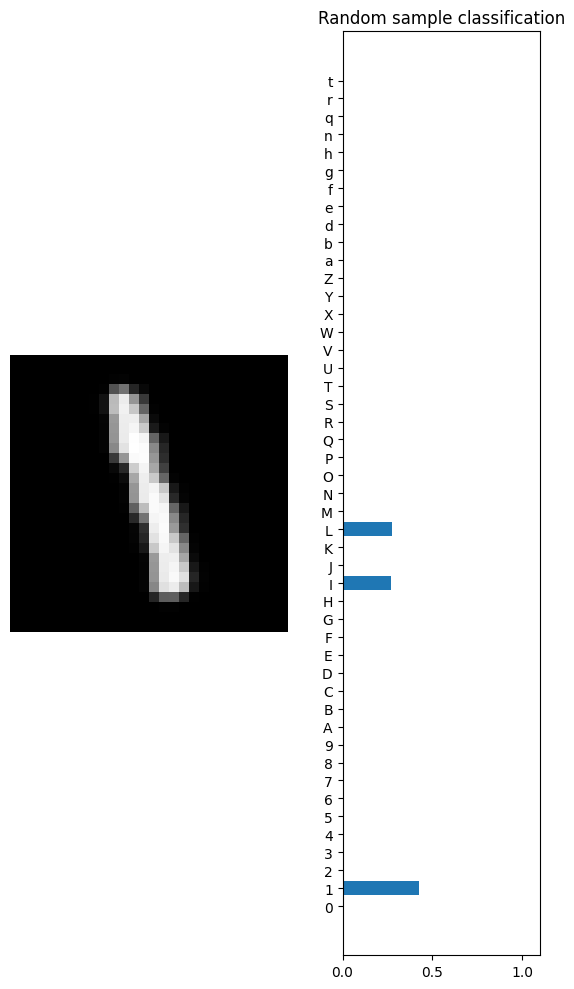

Predicted class: 1


In [347]:
preds_conf, pred_class = random_prediction_example(emnist_dataloader, model)
print(f"Predicted class: {classes_map[pred_class]}")


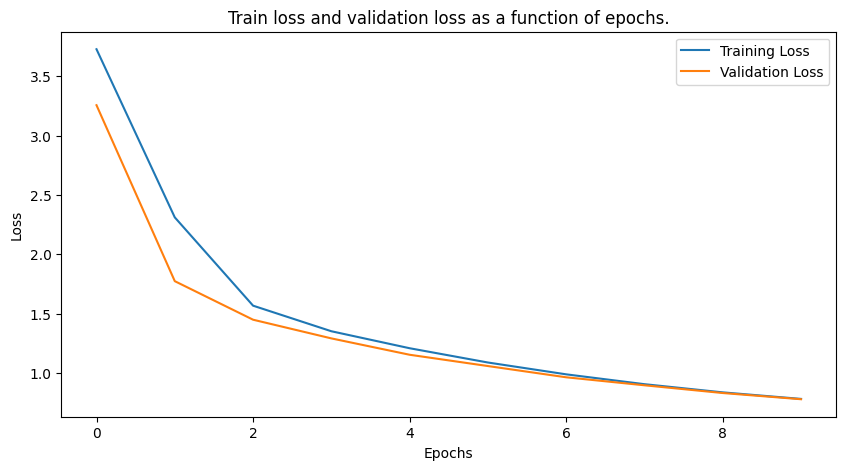

In [348]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Train loss and validation loss as a function of epochs.")
plt.legend()
plt.show()

Create a normal neural network class.

In [350]:
# Check accuracy of the model
def evaluate_model(model, val_loader, is_image_input=False):
    validation_accuracy = 0
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            test_output = model(images)
            ps = torch.exp(test_output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            validation_accuracy += torch.sum(equals.type(torch.FloatTensor))
    res = validation_accuracy / len(val_loader.dataset)
    return res

In [351]:
print(f"Validation accuracy: {evaluate_model(model, val_loader, is_image_input=True)}")

Validation accuracy: 0.7635638117790222


Create a convolutional neural network

In [353]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 47)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
cnn_model = ConvolutionalNet()
print(cnn_model)

ConvolutionalNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=47, bias=True)
)


In [354]:
cnn_epochs = 6
cnn_learning_rate = 0.03

In [355]:
cnn_model = ConvolutionalNet()
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=cnn_learning_rate)

cnn_criterion = nn.NLLLoss()

train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion, cnn_epochs,
                                       train_loader, val_loader, is_image_input=False)

Epoch: 1/6..  Training Loss: 1.726..  Validation Loss: 0.704.. 
Epoch: 2/6..  Training Loss: 0.624..  Validation Loss: 0.558.. 
Epoch: 3/6..  Training Loss: 0.510..  Validation Loss: 0.496.. 
Epoch: 4/6..  Training Loss: 0.456..  Validation Loss: 0.455.. 
Epoch: 5/6..  Training Loss: 0.421..  Validation Loss: 0.431.. 
Epoch: 6/6..  Training Loss: 0.399..  Validation Loss: 0.424.. 


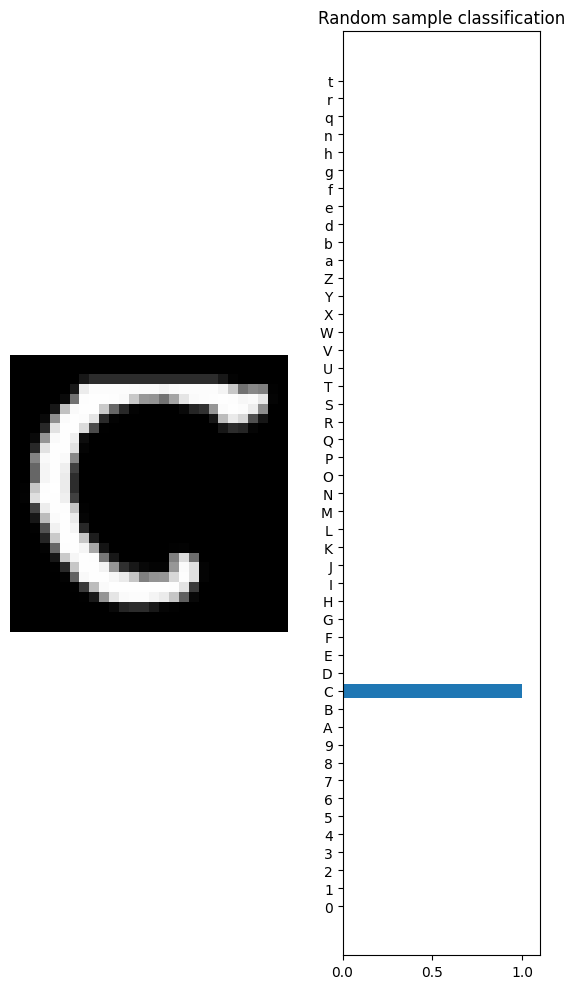

Predicted class: C


In [359]:
preds_conf, pred_class = random_prediction_example(emnist_dataloader, cnn_model)
print(f"Predicted class: {classes_map[pred_class]}")

In [360]:
print(f"Validation accuracy: {evaluate_model(cnn_model, val_loader, is_image_input=False)}")

Validation accuracy: 0.8554964661598206
